In [ ]:
'''
Annotated VCF files generated from SnpEff contain a wealth of information about the functional impact of variants. 
We need to extract and interpret this information
'''


In [3]:
import allel
import numpy as np
# Load the annotated VCF
callset = allel.read_vcf("./annotated_vcfs/1069_variants_annotated.vcf", fields=['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS','ANN'])

# Extracting data
genotypes = allel.GenotypeArray(callset['calldata/GT'])
annotations = callset['variants/ANN']
samples = callset['samples']
chromosomes = callset['variants/CHROM']
positions = callset['variants/POS']

# File to write output
output_file_path = '1069_variants_annotated.txt'
with open(output_file_path, 'w') as output_file:
    # Iterate over samples and variants
    for sample_idx, sample in enumerate(samples):
        for variant_idx, genotype in enumerate(genotypes[:, sample_idx]):
            # Check if the genotype is not homozygous reference (0/0)
            if not np.array_equal(genotype, [0, 0]):
                ann_info = annotations[variant_idx]
                chrom = chromosomes[variant_idx]
                pos = positions[variant_idx]
                # Write to file
                output_file.write(f"Sample {sample}, Variant {variant_idx}, Chromosome {chrom}, Position {pos}: {ann_info}\n")

In [9]:
'''
Calculating Ka/Ks (Non-synonymous/synonymous substitution rate) ratio
'''
import allel
import numpy as np
import pandas as pd
# Load the annotated VCF
callset = allel.read_vcf("./annotated_vcfs/1051_variants_annotated.vcf", fields=['samples', 'calldata/GT','ANN'])

# Extract necessary information
samples = callset['samples']
genotypes = allel.GenotypeArray(callset['calldata/GT'])
annotations = callset['variants/ANN']

# Initialize a dictionary to store counts
# Structure: mutations[sample][gene]['nonsynonymous' or 'synonymous']
mutations = {sample: {} for sample in samples}

for i, ann in enumerate(annotations):
    for effect in ann.split(','):
        # Parse the effect details
        details = effect.split('|')
        effect_type = details[1]  # Assuming the second field is the effect type
        gene_name = details[3]  # Adjust according to your annotation format

        # Determine mutation type
        mutation_type = None
        if 'missense_variant' in effect_type or 'stop_gained' in effect_type:
            mutation_type = 'nonsynonymous'
        elif 'synonymous_variant' in effect_type:
            mutation_type = 'synonymous'
        
        # Skip if not a target mutation type
        if not mutation_type:
            continue

        # Check each sample for the variant
        for sample_idx, sample in enumerate(samples):
            if np.any(genotypes[i, sample_idx] > 0):  # Variant present in this sample
                if gene_name not in mutations[sample]:
                    mutations[sample][gene_name] = {'nonsynonymous': 0, 'synonymous': 0}
                mutations[sample][gene_name][mutation_type] += 1

# Calculate Ka/Ks ratios and prepare the table
data = []
for sample, genes in mutations.items():
    for gene, counts in genes.items():
        ka = counts['nonsynonymous']
        ks = counts['synonymous']
        ratio = ka / ks if ks > 0 else 'inf'  # Handle division by zero
        data.append([sample, gene, ka, ks, ratio])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Sample', 'Gene', 'Ka', 'Ks', 'Ka/Ks Ratio'])

# Display or save the table
print(df)

# Optionally, save the table to a CSV file
df.to_csv('ka_ks_ratios_1051.csv', index=False)

/Users/congliu/miniconda3/envs/popgen/lib/python3.11/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


       Sample       Gene  Ka  Ks Ka/Ks Ratio
0      P1-A03       FLO9  11  29     0.37931
1      P1-A03       GPB2   1   1         1.0
2      P1-A03       GEM1   1   0         inf
3      P1-A03  YAL037C-B   1   0         inf
4      P1-A03      FUN19   1   1         1.0
...       ...        ...  ..  ..         ...
29093  P2-H04       RRG8   1   0         inf
29094  P2-H04      MSS18   0   1         0.0
29095  P2-H04       DPB2   1   0         inf
29096  P2-H04       OPT2   0   1         0.0
29097  P2-H04    YPR202W   1   0         inf

[29098 rows x 5 columns]


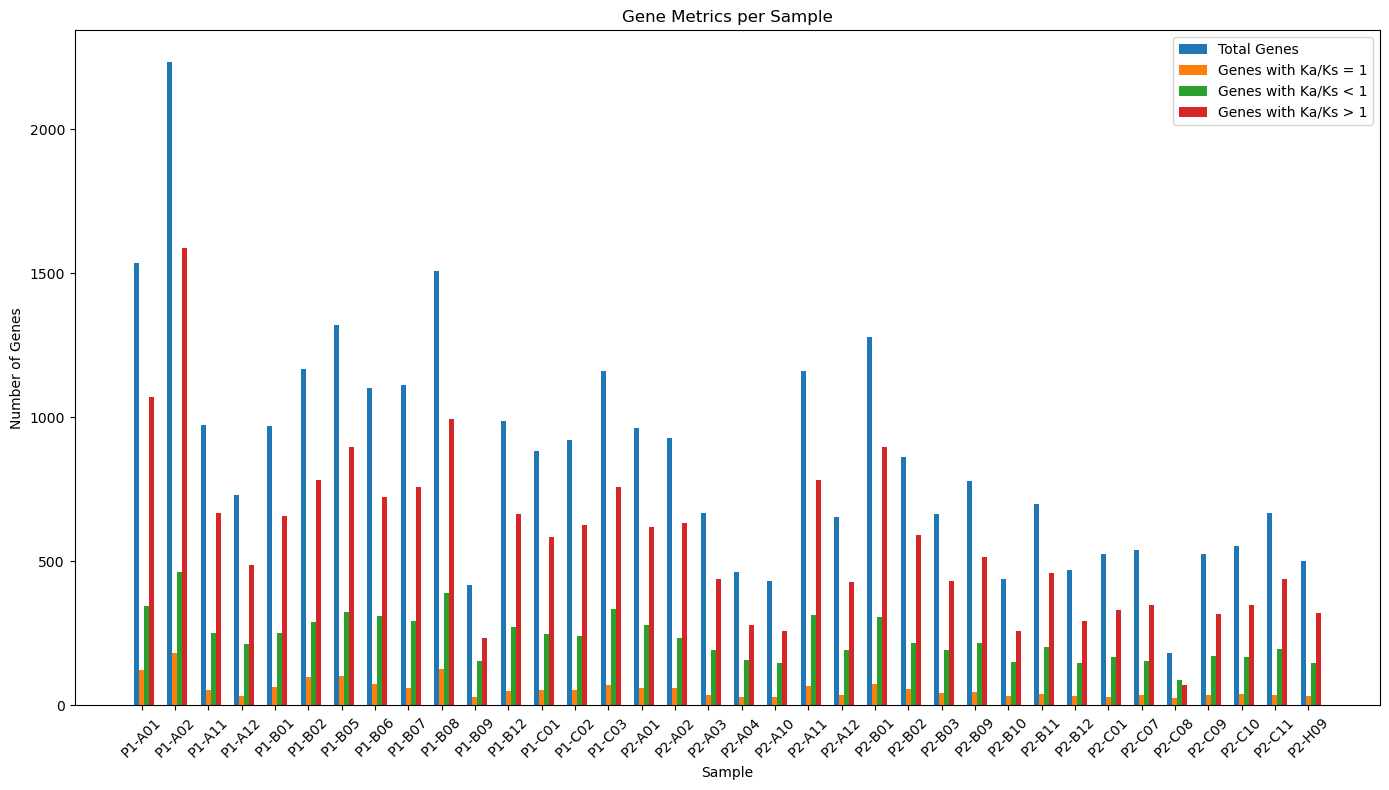

In [27]:
'''
making figures for the results
'''

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('ka_ks_ratios_1069.csv')

# Initialize a dictionary to store your aggregated data
data = {
    'Sample': [],
    'Total Genes': [],
    'Genes with Ka/Ks = 1': [],
    'Genes with Ka/Ks < 1': [],
    'Genes with Ka/Ks > 1': []
}

# Populate the dictionary
for sample in df['Sample'].unique():
    sample_df = df[df['Sample'] == sample]
    data['Sample'].append(sample)
    data['Total Genes'].append(len(sample_df))
    data['Genes with Ka/Ks = 1'].append(len(sample_df[sample_df['Ka/Ks Ratio'] == 1]))
    data['Genes with Ka/Ks < 1'].append(len(sample_df[sample_df['Ka/Ks Ratio'] < 1]))
    data['Genes with Ka/Ks > 1'].append(len(sample_df[sample_df['Ka/Ks Ratio'] > 1]))

# Convert the dictionary to a DataFrame
agg_df = pd.DataFrame(data)
agg_df.to_csv('gene_metrics_1069.csv', index=False)

# Set up the plot
plt.figure(figsize=(14, 8))

# Define the number of groups and bar width
n_groups = len(agg_df)
bar_width = 0.15

# Create the bar plot
for i, column in enumerate(['Total Genes','Genes with Ka/Ks = 1', 'Genes with Ka/Ks < 1', 'Genes with Ka/Ks > 1']):
    plt.bar(np.arange(n_groups) + i * bar_width, agg_df[column], width=bar_width, label=column)

# Add labels, title, and legend
plt.xlabel('Sample')
plt.ylabel('Number of Genes')
plt.title('Gene Metrics per Sample')
plt.xticks(np.arange(n_groups) + bar_width, agg_df['Sample'], rotation=45)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


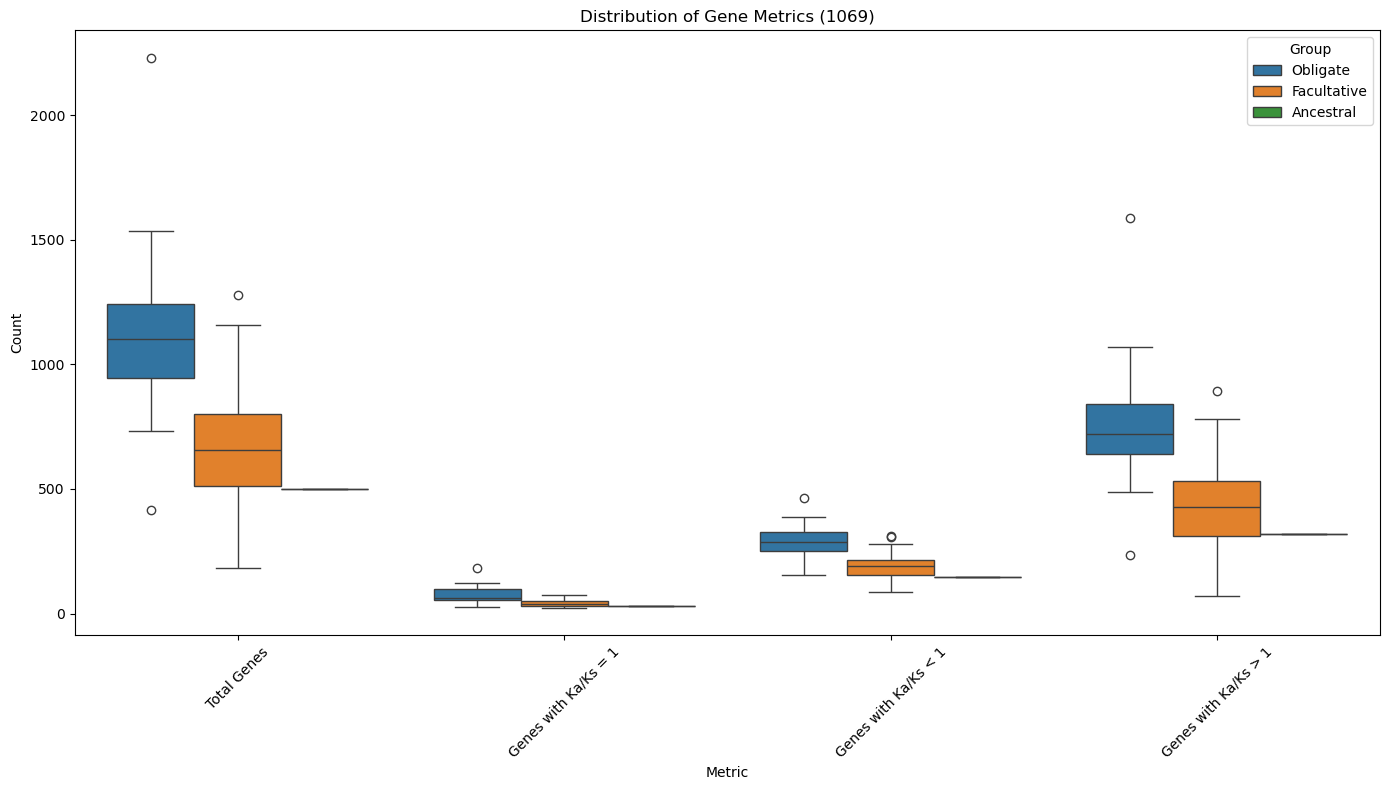

In [76]:
'''
boxplot
'''
df = pd.read_csv('gene_metrics_1069.csv')

# Melt the DataFrame to long format while retaining the 'Sample' column
df_melted = df.melt(id_vars=['Group', 'Sample'], var_name='Metric', value_name='Count')

# Assuming df_melted is already loaded from the previous steps
# Ensure 'Metric' and 'Group' are of type string, and 'Count' is numeric
df_melted['Metric'] = df_melted['Metric'].astype(str)
df_melted['Group'] = df_melted['Group'].astype(str)
df_melted['Count'] = pd.to_numeric(df_melted['Count'], errors='coerce')  # Convert 'Count' to numeric, coerce errors

# Now, try plotting again
plt.figure(figsize=(14, 8))
sns.boxplot(data=df_melted, x='Metric', y='Count', hue='Group')
plt.title('Distribution of Gene Metrics (1069)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('./figures/1069/gene_metrics.pdf') 
plt.show()


Groups in dataset: ['Obligate' 'Facultative' 'Ancestral']


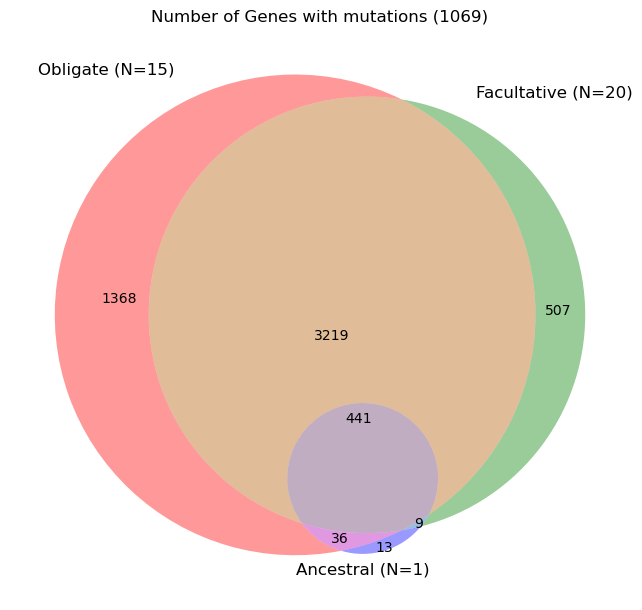

In [92]:
''' create a Venn diagram showing the number of genes shared among each group as well as the number of unique genes in each group
'''

import pandas as pd

# Load the dataset
df = pd.read_csv("ka_ks_ratios_1069.csv")

# This is a placeholder step; actual aggregation will depend on the file's contents
groups = df['Group'].unique()
print("Groups in dataset:", groups)

# Example for extracting gene sets for three groups - adjust as per your data
group1_genes = set(df[df['Group'] == 'Obligate']['Gene'])
group2_genes = set(df[df['Group'] == 'Facultative']['Gene'])
group3_genes = set(df[df['Group'] == 'Ancestral']['Gene'])

# Plot the venn 
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venn3([group1_genes, group2_genes, group3_genes], ('Obligate (N=15)', 'Facultative (N=20)', 'Ancestral (N=1)'))
plt.title('Number of Genes with mutations (1069)')
plt.savefig('./figures/1069/venn_1069.pdf') 
plt.show()


Groups in dataset: ['Obligate' 'Facultative' 'Ancestral']


<Figure size 1600x1600 with 0 Axes>

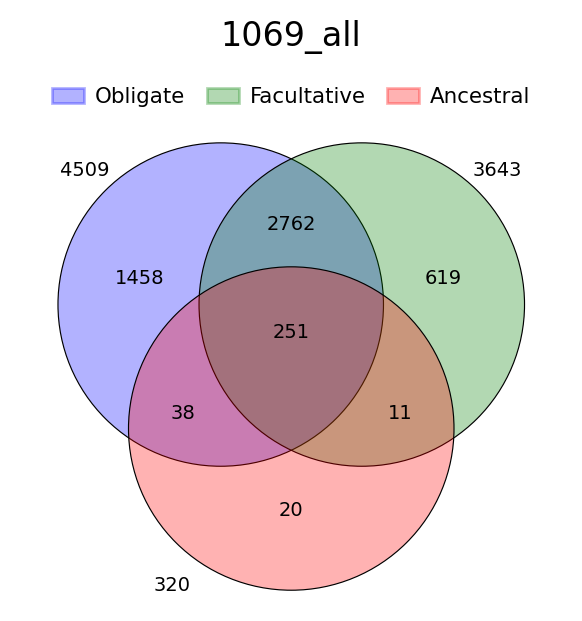

In [76]:
''' create a Venn diagram showing the number of genes shared among each group as well as the number of unique genes in each group
Filter: gene under positive seleciton ka/ks >1
'''

import pandas as pd

# Load the dataset
df = pd.read_csv("ka_ks_ratios_1069.csv")
df_filtered = df[df['Ka/Ks Ratio'] > 1]

# This is a placeholder step; actual aggregation will depend on the file's contents
groups = df_filtered['Group'].unique()
print("Groups in dataset:", groups)

# Example for extracting gene sets for three groups - adjust as per your data
group1_genes = set(df_filtered[df_filtered['Group'] == 'Obligate']['Gene'])
group2_genes = set(df_filtered[df_filtered['Group'] == 'Facultative']['Gene'])
group3_genes = set(df_filtered[df_filtered['Group'] == 'Ancestral']['Gene'])

sets = {
    'Obligate': group1_genes,
    'Facultative': group2_genes,
    'Ancestral': group3_genes}

# Plot the venn 
from venny4py.venny4py import * 
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venny4py(sets=sets)
plt.title('1069_all')
plt.savefig('./figures/1069/venn_1069_positive_selection_all.pdf') 
plt.show()

Culture_ID in dataset: ['A39' 'A41' 'A47']
Total number of gene: 4509


<Figure size 1600x1600 with 0 Axes>

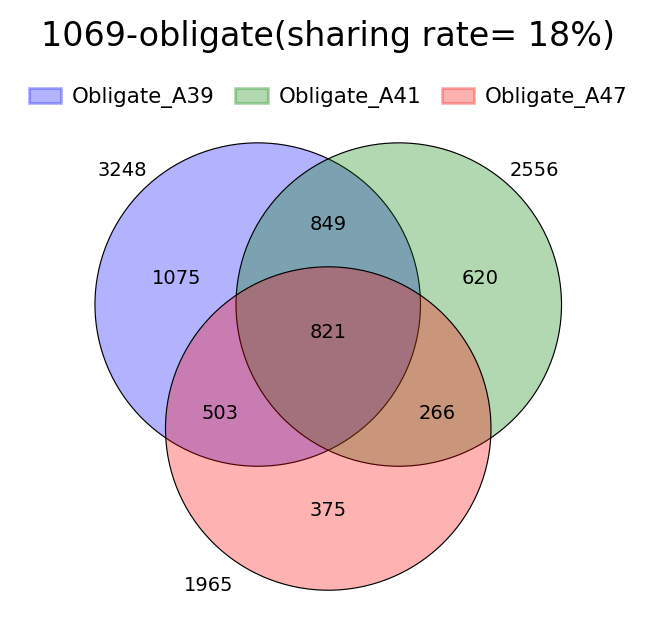

In [79]:
''' create a Venn diagram showing the number of genes shared among each group as well as the number of unique genes in each group
Filter: gene under positive seleciton ka/ks >1
'''

import pandas as pd

# Load the dataset
df = pd.read_csv("ka_ks_ratios_1069.csv")
df_filtered = df[df['Ka/Ks Ratio'] > 1]
df_filtered_obli =df_filtered[df_filtered['Group']=='Obligate']

# This is a placeholder step; actual aggregation will depend on the file's contents
groups = df_filtered_obli['Culture_ID'].unique()
print("Culture_ID in dataset:", groups)

# Example for extracting gene sets for three groups - adjust as per your data
group1_genes = set(df_filtered_obli[df_filtered_obli['Culture_ID'] == 'A39']['Gene'])
group2_genes = set(df_filtered_obli[df_filtered_obli['Culture_ID'] == 'A41']['Gene'])
group3_genes = set(df_filtered_obli[df_filtered_obli['Culture_ID'] == 'A47']['Gene'])
print("Total number of gene:",len(df_filtered_obli.Gene.unique())) #total number of gene
sets = {
    'Obligate_A39': group1_genes,
    'Obligate_A41': group2_genes,
    'Obligate_A47': group3_genes}

# Plot the venn 
from venny4py.venny4py import * 
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venny4py(sets=sets)
plt.title('1069-obligate(sharing rate= 18%)')
plt.savefig('./figures/1069/venn_1069_positive_selection_obligate.pdf') 
plt.show()

In [78]:
821/4509

0.18208028387669106

In [71]:
663/4200

0.15785714285714286

In [ ]:

# Load the dataset
df = pd.read_csv("ka_ks_ratios_1069.csv")
df_filtered = df[df['Ka/Ks Ratio'] > 1]
df_filtered_f =df_filtered[df_filtered['Group']=='Facultative']

# This is a placeholder step; actual aggregation will depend on the file's contents
groups = df_filtered_f['Culture_ID'].unique()
print("Culture_ID in dataset:", groups)

# Example for extracting gene sets for three groups - adjust as per your data
group1_genes = set(df_filtered_f[df_filtered_f['Culture_ID'] == '5D']['Gene'])
group2_genes = set(df_filtered_f[df_filtered_f['Culture_ID'] == '5G']['Gene'])
group3_genes = set(df_filtered_f[df_filtered_f['Culture_ID'] == '6B']['Gene'])
group4_genes = set(df_filtered_f[df_filtered_f['Culture_ID'] == '6H']['Gene'])
sets = {
    'Facultative_5D': group1_genes,
    'Facultative_5G': group2_genes,
    'Facultative_6B': group3_genes,
    'Facultative_5H': group4_genes}
print("Total number of gene:",len(df_filtered_f.Gene.unique())) #total number of gene
# Plot the venn 
from venny4py.venny4py import * # VENN WITH 4 GROUPS
import matplotlib.pyplot as plt

# Create a Venn diagram
plt.figure(figsize=(8, 8))
venny4py(sets=sets)
plt.title('1069-Facultative(sharing rate= 6%)')
plt.savefig('./figures/1069/venn_1069_positive_selection_facultative.pdf') 
plt.show()

In [4]:
'''output the unique genes for each group along with their Ka/Ks values'''
import pandas as pd

# Load the dataset
df = pd.read_csv("ka_ks_ratios_1069.csv")
df_filtered = df[df['Ka/Ks Ratio'] > 1]
# Get unique groups
groups = df_filtered['Group'].unique()

# Prepare a dictionary to hold unique genes for each group
unique_genes_info = {group: None for group in groups}

for group in groups:
    # Genes in the current group
    current_genes = set(df_filtered[df_filtered['Group'] == group]['Gene'])
    
    # Genes in other groups
    other_genes = set(df_filtered[df_filtered['Group'] != group]['Gene'])
    
    # Find genes unique to the current group
    unique_genes = current_genes - other_genes
    
    # Extract rows for unique genes
    unique_genes_df = df_filtered[(df_filtered['Gene'].isin(unique_genes)) & (df_filtered['Group'] == group)]
    
    # Store in dict
    unique_genes_info[group] = unique_genes_df[['Gene', 'Ka/Ks Ratio']]
    
    # Optional: print or save to CSV
    print(f"Unique genes for {group}:")
    print(unique_genes_info[group], "\n")  # Printing; replace with saving logic if desired

for group, unique_genes_df in unique_genes_info.items():
    output_path = f'unique_genes1069_{group}.csv'
    unique_genes_df.to_csv(output_path, index=False)
    print(f"Saved unique genes for {group} to {output_path}")


Unique genes for Obligate:
            Gene  Ka/Ks Ratio
2           FLC2          inf
3           OAF1          inf
4          SPC72          inf
20          PSK1          inf
25         BUD14          inf
...          ...          ...
16990    YPR096C          inf
16992       PIS1          inf
17001  tI(AAU)P1          inf
17005       VPS4          inf
17013    YPR196W          inf

[2568 rows x 2 columns] 

Unique genes for Facultative:
          Gene  Ka/Ks Ratio
17054     POP8     1.333333
17075     YRO2          inf
17088  YBR144C          inf
17093     UBS1          inf
17118     EGO2          inf
...        ...          ...
30351     AHC1          inf
30373     SER1          inf
30384     PAC1          inf
30400     RKM1          inf
30436     ARO7          inf

[894 rows x 2 columns] 

Unique genes for Ancestral:
            Gene  Ka/Ks Ratio
30455    YAL045C          inf
30496       CSG2          inf
30514      PET18          inf
30571       CHZ1          inf
30579  YER088C-A

In [22]:
## extract gene info. from annotated vcf file.

import allel
import numpy as np
import pandas as pd

# Load the annotated VCF
callset = allel.read_vcf("./annotated_vcfs/1069_variants_annotated.vcf", fields=['samples', 'calldata/GT', 'variants/CHROM', 'variants/POS', 'variants/ANN'])

# Extract necessary information
samples = callset['samples']
chromosomes = callset['variants/CHROM']
positions = callset['variants/POS']
annotations = callset['variants/ANN']
genotypes = allel.GenotypeArray(callset['calldata/GT'])

# Prepare data for CSV output
data = []

# Iterate through each variant
for i, ann in enumerate(annotations):
    chrom = chromosomes[i]
    pos = positions[i]
    
    # Split ANN field to extract gene name and gene ID
    for effect in ann.split(','):
        details = effect.split('|')
        gene_name = details[3]  # Adjust according to your annotation format
        gene_id = details[4]    # Adjust according to your annotation format
        
        # Check each sample for the variant
        for sample_idx, sample in enumerate(samples):
            if np.any(genotypes[i, sample_idx] > 0):  # Variant present in this sample
                # Append information to data list
                data.append([sample, chrom, pos, gene_name, gene_id])

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Sample ID', 'Chromosome', 'Position', 'Gene Name', 'Gene ID'])

# Display or save the table
print(df.head())  # Display the first few rows

# Save the DataFrame to a CSV file
df.to_csv('1069_variants_info.csv', index=False)


/Users/congliu/miniconda3/envs/popgen/lib/python3.11/site-packages/allel/io/vcf_read.py:1732: UserWarning: invalid INFO header: '##INFO=<ID=VDB,Number=1,Type=Float,Description="Variant Distance Bias for filtering splice-site artefacts in RNA-seq data (bigger is better)",Version="3">\n'
  warnings.warn('invalid INFO header: %r' % header)


  Sample ID Chromosome  Position  Gene Name    Gene ID
0    P1-A02          I       149    YAL069W    YAL069W
1    P1-A01          I      1179  YAL067W-A  YAL067W-A
2    P1-A01          I      1193  YAL067W-A  YAL067W-A
3    P1-A01          I      1197  YAL067W-A  YAL067W-A
4    P1-A01          I      2435       PAU8    YAL068C
